# Import Packages

In [1]:
# built-in
import itertools
import os
from os import path

# third-party (install required)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
from tqdm import tqdm_notebook as tqdm

sns.set_style('ticks')

# Setup

## Define QC Thresholds

In [2]:
min_pct_aligned = 40 # Minimum percent of reads aligned to genome
min_mrna_reads = 5e5 # Minimum number of reads mapped to mRNA

## Define Data File Path

<font size="4">Show files in the organism directory</font>

In [3]:
org_dir = path.join('../../data/precise1k/')
os.listdir(org_dir)

['precise1k.json.gz',
 'A.csv',
 'multiqc_report.html',
 'multiqc_data',
 '.DS_Store',
 'deg',
 'imodulon_table.csv',
 'log_tpm_qc.csv',
 'counts.csv',
 'log_tpm_qc_w_short_low_fpkm.csv',
 'log_tpm_norm_qc.csv',
 'ros_tale_metadata_simple.csv',
 'metadata_qc.csv',
 'crp_binding.csv',
 'metadata.csv',
 'log_tpm.csv',
 'multiqc_stats.tsv',
 'optica',
 'M.csv',
 'component_stats.csv']

<font size="4">Enter name of curated metadata file here</font>

In [4]:
metadata_file = "metadata.csv"

## Load Expression Data

In [5]:
DF_log_tpm = pd.read_csv(path.join(org_dir,'log_tpm.csv'),index_col=0).fillna(0)
print('Number of genes:',DF_log_tpm.shape[0])
print('Number of samples:',DF_log_tpm.shape[1])

Number of genes: 4355
Number of samples: 1055


In [6]:
DF_log_tpm.head()

,p1k_00001,p1k_00002,p1k_00003,p1k_00004,p1k_00005,p1k_00006,p1k_00007,p1k_00008,p1k_00009,p1k_00010,...,p1k_01046,p1k_01047,p1k_01048,p1k_01049,p1k_01050,p1k_01051,p1k_01052,p1k_01053,p1k_01054,p1k_01055
b0001,10.473722,10.271944,6.238716,6.608165,9.864757,10.307053,5.566346,6.535876,10.315486,10.808134,...,9.600793,9.234737,9.607747,9.894369,9.839448,9.892174,9.988233,9.488565,9.221845,10.170968
b0002,10.260569,10.368555,11.193605,11.404163,10.497016,10.235690,9.477470,9.811860,10.735874,10.726916,...,9.446533,8.302502,8.452109,8.363976,8.672402,8.647693,9.675175,8.761815,8.421964,8.483203
b0003,9.920277,10.044224,11.045580,11.460140,10.374823,10.216922,9.219235,9.861262,10.528432,10.503092,...,8.480662,7.449754,7.467061,7.538769,7.723832,7.670143,8.857956,7.922229,7.633727,7.859478
b0004,9.936694,10.010638,9.976798,10.330368,9.876910,9.638754,8.258753,8.650959,9.739519,9.722997,...,9.282031,8.281564,8.364711,8.249902,8.597246,8.722178,9.444481,8.395833,8.590145,8.446588
b0005,7.027515,7.237449,6.014337,5.854519,6.950936,6.768425,5.011006,5.137711,6.745798,6.497823,...,4.206849,2.505517,3.065065,4.168111,4.056920,4.030515,4.921936,3.311463,2.568554,4.185822


## Load QC Data
<font size="4">There may be some datasets that failed along the processing pipeline, so the number of samples with QC data may be higher than the number of samples with expression data.</font>

In [7]:
DF_qc_stats = pd.read_csv(path.join(org_dir,'multiqc_stats.tsv'),index_col=0, sep='\t')
print('Number of samples with QC data:',DF_qc_stats.shape[0])

Number of samples with QC data: 1055


In [8]:
DF_qc_stats.fillna(0,inplace=True)
DF_qc_stats.head()

,Total,Assigned,Unassigned_rRNA,Unassigned_Unmapped,Unassigned_Read_Type,Unassigned_Singleton,Unassigned_MappingQuality,Unassigned_Chimera,Unassigned_FragmentLength,Unassigned_Duplicate,...,r_written,bp_processed,quality_trimmed,bp_written,percent_trimmed,pe_sense,pe_antisense,failed,se_sense,se_antisense
Sample,,,,,,,,,,,,,,,,,,,,,
p1k_00001,6372886,4580247,53735,229666,0,0,0,0,164092,0,...,6496162,201381022,10060007,188572802,6.360192,0.0399,0.4468,0.5133,0.0,0.0
p1k_00002,4346353,3183361,26601,199565,0,0,0,0,85134,0,...,4394188,136219828,6035575,128348546,5.778367,0.0409,0.4453,0.5138,0.0,0.0
p1k_00003,11421794,8766507,5167,179345,0,0,0,0,12588,0,...,11445313,354804703,6338224,346636233,2.302244,0.0261,0.5113,0.4626,0.0,0.0
p1k_00004,10539531,7948109,2908,131778,0,0,0,0,4483,0,...,10563549,327470019,6001546,319757327,2.355236,0.0234,0.5314,0.4452,0.0,0.0
p1k_00005,10713890,8153915,1175,562512,0,0,0,0,41171,0,...,10848313,336297703,8690930,325858317,3.104210,0.0314,0.4550,0.5135,0.0,0.0


## Load Metadata

In [9]:
DF_metadata = pd.read_csv(path.join(org_dir,metadata_file),index_col=0)
print('Number of samples with metadata:',DF_metadata.shape[0])
DF_metadata.head()

Number of samples with metadata: 1055


,sample_id,study,project,condition,rep_id,Strain Description,Strain,Culture Type,Evolved Sample,Base Media,...,Platform,Biological Replicates,DOI,GEO,SRX,Run,R1,R2,contact,creator
Experiment,,,,,,,,,,,,,,,,,,,,,
p1k_00001,control__wt_glc__1,Control,control,wt_glc,1,Escherichia coli K-12 MG1655,MG1655,Batch,No,M9,...,ILLUMINA,2.0,doi.org/10.1093/nar/gky069,GSE65643,SRX865357,SRR1787590,s3://precise-db/raw_data/control/MG1655-M9-glu...,s3://precise-db/raw_data/control/MG1655-M9-glu...,Sangwoo Seo,Sangwoo Seo
p1k_00002,control__wt_glc__2,Control,control,wt_glc,2,Escherichia coli K-12 MG1655,MG1655,Batch,No,M9,...,ILLUMINA,2.0,doi.org/10.1093/nar/gky069,GSE65643,SRX865358,SRR1787591,s3://precise-db/raw_data/control/MG1655-M9-glu...,s3://precise-db/raw_data/control/MG1655-M9-glu...,Sangwoo Seo,Sangwoo Seo
p1k_00003,fur__wt_dpd__1,Fur,fur,wt_dpd,1,Escherichia coli K-12 MG1655,MG1655,Batch,No,M9,...,ILLUMINA,2.0,doi.org/10.1038/ncomms5910,GSE54900,SRX469840,SRR1168135,s3://precise-db/raw_data/fur/WTDPD1_S1_L001_R1...,s3://precise-db/raw_data/fur/WTDPD1_S1_L001_R2...,Sangwoo Seo,Sangwoo Seo
p1k_00004,fur__wt_dpd__2,Fur,fur,wt_dpd,2,Escherichia coli K-12 MG1655,MG1655,Batch,No,M9,...,ILLUMINA,2.0,doi.org/10.1038/ncomms5910,GSE54900,SRX469841,SRR1168136,s3://precise-db/raw_data/fur/WTDPD2_S1_L001_R1...,s3://precise-db/raw_data/fur/WTDPD2_S1_L001_R2...,Sangwoo Seo,Sangwoo Seo
p1k_00005,fur__wt_fe__1,Fur,fur,wt_fe,1,Escherichia coli K-12 MG1655,MG1655,Batch,No,M9,...,ILLUMINA,2.0,doi.org/10.1038/ncomms5910,GSE54900,SRX469838,SRR1168133,s3://precise-db/raw_data/fur/WT-Fe2-1_S1_L001_...,s3://precise-db/raw_data/fur/WT-Fe2-1_S1_L001_...,Sangwoo Seo,Sangwoo Seo


In [10]:
# Ensure that metadata and qc_stats data contain all log_tpm sample information
assert(set(DF_log_tpm.columns) - set(DF_metadata.index) == set())
assert(set(DF_log_tpm.columns) - set(DF_qc_stats.index) == set())

# Check QC Statistics

## FastQC

In [11]:
fastqc_cols = ['per_base_sequence_quality',
       'per_tile_sequence_quality', 'per_sequence_quality_scores',
       'per_base_sequence_content', 'per_sequence_gc_content',
       'per_base_n_content', 'sequence_length_distribution',
       'sequence_duplication_levels', 'overrepresented_sequences',
       'adapter_content']

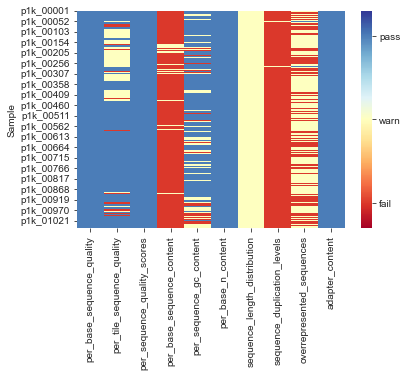

In [12]:
DF_fastqc = DF_qc_stats[fastqc_cols]
ax = sns.heatmap(DF_fastqc.replace('pass',1).replace('warn',0).replace('fail',-1),
            cmap='RdYlBu',vmax=1.3,vmin=-1.3)
cbar = ax.collections[0].colorbar
cbar.set_ticks([-1,0,1])
cbar.set_ticklabels(['fail','warn','pass'])

<font size="4">The following four categories are the most important:
    - per_base_sequence_quality
    - per_sequence_quality_scores
    - per_base_n_content
    - adapter_content
    
If a sample does not pass any of these four categories, discard the sample
</font>

In [13]:
fastqc_fail_cols = ['per_base_sequence_quality','per_sequence_quality_scores','per_base_n_content','adapter_content']

In [14]:
DF_failed_fastqc = DF_fastqc[fastqc_fail_cols][(DF_fastqc[fastqc_fail_cols] == 'fail').any(axis=1)]
DF_failed_fastqc[fastqc_fail_cols]

,per_base_sequence_quality,per_sequence_quality_scores,per_base_n_content,adapter_content
Sample,,,,
p1k_00013,fail,warn,pass,pass
p1k_00069,fail,pass,fail,pass
p1k_00076,fail,pass,fail,pass


<font size="4">Mark samples as failed.</font>

In [15]:
DF_metadata['passed_fastqc'] = ~DF_metadata.index.isin(DF_failed_fastqc.index)

## Read Alignment Percentage

In [16]:
align_cols = ['Assigned']
total_alignment = DF_qc_stats[align_cols].sum(axis=1)
percent_alignment = total_alignment.divide(DF_qc_stats['Total'])*100

Text(0.5, 1.0, 'Histogram of Alignment Percentage')

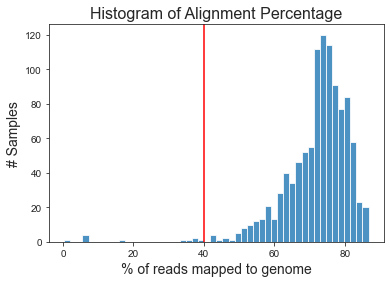

In [17]:
fig,ax = plt.subplots()
ax.hist(percent_alignment,bins=50,alpha=0.8)
ymin,ymax = ax.get_ylim()
ax.vlines(min_pct_aligned,ymin,ymax,color='r')
ax.set_ylim((ymin,ymax))
ax.set_xlabel('% of reads mapped to genome',fontsize=14)
ax.set_ylabel('# Samples',fontsize=14)
ax.set_title('Histogram of Alignment Percentage',fontsize=16)

In [18]:
DF_failed_mapping = DF_qc_stats[percent_alignment < min_pct_aligned]
DF_failed_mapping

,Total,Assigned,Unassigned_rRNA,Unassigned_Unmapped,Unassigned_Read_Type,Unassigned_Singleton,Unassigned_MappingQuality,Unassigned_Chimera,Unassigned_FragmentLength,Unassigned_Duplicate,...,r_written,bp_processed,quality_trimmed,bp_written,percent_trimmed,pe_sense,pe_antisense,failed,se_sense,se_antisense
Sample,,,,,,,,,,,,,,,,,,,,,
p1k_00151,3906008,1537833,1479914,55929,0,0,0,0,9857,0,...,3922738,137295830,143152,135630362,1.213051,0.4081,0.3211,0.2707,0.0,0.0
p1k_00361,6409073,2396849,2999202,80540,0,0,0,0,105408,0,...,6415979,256639160,564443,253273411,1.311471,0.0360,0.2346,0.7294,0.0,0.0
p1k_00397,4837452,809302,3361607,175788,0,0,0,0,47770,0,...,4846082,489454282,2006772,485061325,0.897521,0.0611,0.1761,0.7627,0.0,0.0
p1k_00720,9009414,31284,3668370,859929,0,0,0,0,27719,0,...,9033164,682613640,2339290,678983256,0.531836,0.4545,0.1599,0.3857,0.0,0.0
p1k_00793,4206750,1593431,416287,97804,0,0,0,0,12376,0,...,4208394,214628094,221755,212514750,0.984654,0.0605,0.5627,0.3768,0.0,0.0
p1k_00794,6136173,2135300,1522795,234165,0,0,0,0,23901,0,...,6138877,313082727,360184,309930694,1.006773,0.0507,0.4412,0.5081,0.0,0.0
p1k_00825,2898115,1052668,160744,1214712,0,0,0,0,22273,0,...,2910024,116400960,546282,114474357,1.655144,0.2379,0.3040,0.4581,0.0,0.0
p1k_00886,12188565,726829,10586,10993290,0,0,0,0,110259,0,...,12242707,1236513407,2935808,1223981792,1.013464,0.0582,0.4054,0.5364,0.0,0.0
p1k_00887,13015021,820004,31015,11676995,0,0,0,0,116875,0,...,13080438,1321124238,3286496,1307325241,1.044489,0.0518,0.4032,0.5451,0.0,0.0


In [19]:
DF_metadata['passed_pct_reads_mapped'] = ~DF_metadata.index.isin(DF_failed_mapping.index)

## Aligned Read Count

<font size="4">The following histogram shows how many reads map to coding sequences (i.e. mRNA). Too few aligned reads reduces the sensitivity of the resulting data.</font>

Text(0.5, 1.0, 'Number of reads mapped to CDS')

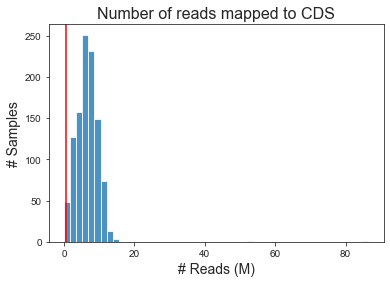

In [20]:
fig,ax = plt.subplots()
ax.hist(DF_qc_stats['Assigned']/1e6,bins=50,alpha=0.8)
ymin,ymax = ax.get_ylim()
ax.vlines(min_mrna_reads/1e6,ymin,ymax,color='r')
ax.set_ylim((ymin,ymax))
ax.set_xlabel('# Reads (M)',fontsize=14)
ax.set_ylabel('# Samples',fontsize=14)
ax.set_title('Number of reads mapped to CDS',fontsize=16)

<font size="4">Identify samples with poor read depth:</font>

In [21]:
DF_failed_mrna = DF_qc_stats[DF_qc_stats['Assigned'] < min_mrna_reads].sort_values('Assigned')
DF_failed_mrna

,Total,Assigned,Unassigned_rRNA,Unassigned_Unmapped,Unassigned_Read_Type,Unassigned_Singleton,Unassigned_MappingQuality,Unassigned_Chimera,Unassigned_FragmentLength,Unassigned_Duplicate,...,r_written,bp_processed,quality_trimmed,bp_written,percent_trimmed,pe_sense,pe_antisense,failed,se_sense,se_antisense
Sample,,,,,,,,,,,,,,,,,,,,,
p1k_00720,9009414,31284,3668370,859929,0,0,0,0,27719,0,...,9033164,682613640,2339290,678983256,0.531836,0.4545,0.1599,0.3857,0.0,0.0


<font size="4">Mark samples as failed.</font>

In [22]:
DF_metadata['passed_reads_mapped_to_CDS'] = ~DF_metadata.index.isin(DF_failed_mrna.index)

# Examine Global Correlations

## Hierarchical Clustering

<font size=4> A clustermap is a great way to visualize the global correlations between one sample and all others. The following code uses hierarchical clustering to identify specific clusters in the clustermap <font size=4>
    
<font size=4> To increase the number of clusters, decrease the value of `thresh`. To decrease the number of clusters, increase the value of `thresh` <font size=4>

In [23]:
import scipy.cluster.hierarchy as sch
import matplotlib.patches as patches
# change this to get different number of clusters
thresh = .3

# retrieve clusters using fcluster 
corr = DF_log_tpm.corr()
corr.fillna(0,inplace=True)
dist = sch.distance.pdist(corr)
link = sch.linkage(dist, method='complete')
clst = pd.DataFrame(index=DF_log_tpm.columns)
clst['cluster'] = sch.fcluster(link, thresh * dist.max(), 'distance')

#get colors for each cluster
cm = plt.cm.get_cmap('tab20')
clr = dict(zip(clst.cluster.unique(), cm.colors))
clst['color'] = clst.cluster.map(clr)

print('Number of cluster: ', len(clr))

Number of cluster:  4


<font size="4">To view sample IDs in the clustermap, set `xticklabels` and `yticklabels` to `True`. You can increase the `size` variable to improve readability of sample IDs<font>

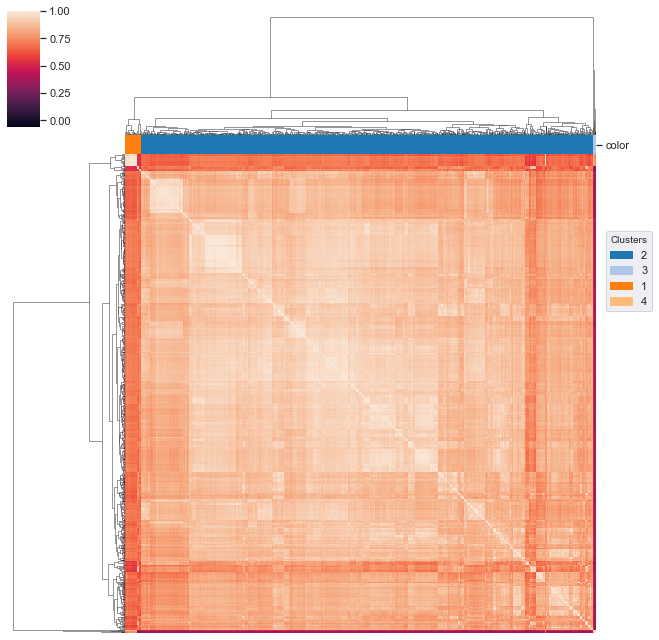

In [24]:
size = 9

legend_TN = [patches.Patch(color=c, label=l) for l,c in clr.items()]

sns.set(rc={'figure.facecolor':'white'})
g = sns.clustermap(DF_log_tpm.corr(), figsize=(size,size), 
                   row_linkage=link, col_linkage=link, col_colors=clst.color,
                  yticklabels=False, xticklabels=False)

l2=g.ax_heatmap.legend(loc='upper left', bbox_to_anchor=(1.01,0.85), handles=legend_TN,frameon=True)
l2.set_title(title='Clusters',prop={'size':10})

<font size="4">Select clusters to remove.</font>

In [25]:
#indicate which clusters you want to remove
remove_clst = [3,4]
failed_global_corr = clst[clst.cluster.isin(remove_clst)].index

In [26]:
clst[clst.cluster.isin(remove_clst)]

,cluster,color
p1k_00156,3,"(0.6823529411764706, 0.7803921568627451, 0.909..."
p1k_00720,4,"(1.0, 0.7333333333333333, 0.47058823529411764)"
p1k_00821,3,"(0.6823529411764706, 0.7803921568627451, 0.909..."
p1k_00822,3,"(0.6823529411764706, 0.7803921568627451, 0.909..."
p1k_00823,3,"(0.6823529411764706, 0.7803921568627451, 0.909..."
p1k_00824,3,"(0.6823529411764706, 0.7803921568627451, 0.909..."
p1k_00825,3,"(0.6823529411764706, 0.7803921568627451, 0.909..."


In [27]:
DF_metadata['passed_global_correlation'] = ~DF_metadata.index.isin(failed_global_corr)

In [28]:
DF_metadata.head()

,sample_id,study,project,condition,rep_id,Strain Description,Strain,Culture Type,Evolved Sample,Base Media,...,SRX,Run,R1,R2,contact,creator,passed_fastqc,passed_pct_reads_mapped,passed_reads_mapped_to_CDS,passed_global_correlation
Experiment,,,,,,,,,,,,,,,,,,,,,
p1k_00001,control__wt_glc__1,Control,control,wt_glc,1,Escherichia coli K-12 MG1655,MG1655,Batch,No,M9,...,SRX865357,SRR1787590,s3://precise-db/raw_data/control/MG1655-M9-glu...,s3://precise-db/raw_data/control/MG1655-M9-glu...,Sangwoo Seo,Sangwoo Seo,True,True,True,True
p1k_00002,control__wt_glc__2,Control,control,wt_glc,2,Escherichia coli K-12 MG1655,MG1655,Batch,No,M9,...,SRX865358,SRR1787591,s3://precise-db/raw_data/control/MG1655-M9-glu...,s3://precise-db/raw_data/control/MG1655-M9-glu...,Sangwoo Seo,Sangwoo Seo,True,True,True,True
p1k_00003,fur__wt_dpd__1,Fur,fur,wt_dpd,1,Escherichia coli K-12 MG1655,MG1655,Batch,No,M9,...,SRX469840,SRR1168135,s3://precise-db/raw_data/fur/WTDPD1_S1_L001_R1...,s3://precise-db/raw_data/fur/WTDPD1_S1_L001_R2...,Sangwoo Seo,Sangwoo Seo,True,True,True,True
p1k_00004,fur__wt_dpd__2,Fur,fur,wt_dpd,2,Escherichia coli K-12 MG1655,MG1655,Batch,No,M9,...,SRX469841,SRR1168136,s3://precise-db/raw_data/fur/WTDPD2_S1_L001_R1...,s3://precise-db/raw_data/fur/WTDPD2_S1_L001_R2...,Sangwoo Seo,Sangwoo Seo,True,True,True,True
p1k_00005,fur__wt_fe__1,Fur,fur,wt_fe,1,Escherichia coli K-12 MG1655,MG1655,Batch,No,M9,...,SRX469838,SRR1168133,s3://precise-db/raw_data/fur/WT-Fe2-1_S1_L001_...,s3://precise-db/raw_data/fur/WT-Fe2-1_S1_L001_...,Sangwoo Seo,Sangwoo Seo,True,True,True,True


# Remove Failed Samples

In [29]:
qc_columns = ['passed_fastqc',
              'passed_reads_mapped_to_CDS',
              'passed_global_correlation']

In [30]:
pass_qc = DF_metadata[qc_columns].all(axis=1)
DF_metadata_passed = DF_metadata[pass_qc]

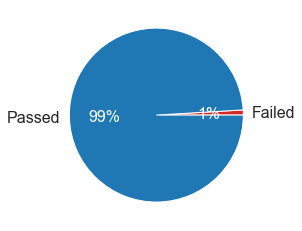

In [31]:
_,_,pcts = plt.pie(pass_qc.value_counts().sort_values(),
        labels = ['Failed','Passed'],
        colors=['tab:red','tab:blue'],
        autopct='%.0f%%',textprops={'size':16});

# Colors percents white
for pct in pcts:
    pct.set_color('white')

# Replicates

<font size="4">Once you have updated your metadata files with the sample information, we can investigate correlations between biological replicates. We require biological replicates to have a Pearson R correlation above 0.95. </font>

## Replicate Correlations

In [32]:
DF_metadata_passed['full_name'] = DF_metadata_passed.loc[:,'project'].str.cat(
    DF_metadata_passed.loc[:,'condition'],sep=':'
)

/var/folders/q2/bdjskmzs1n9fbb14bmvhdz500000gn/T/ipykernel_61536/3293892497.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DF_metadata_passed['full_name'] = DF_metadata_passed.loc[:,'project'].str.cat(


In [33]:
rep_corrs = {}
rand_corrs = {}

num_comparisons = len(DF_metadata_passed)*(len(DF_metadata_passed)-1)/2
for exp1,exp2 in tqdm(itertools.combinations(DF_metadata_passed.index,2),total=num_comparisons):
    if DF_metadata_passed.loc[exp1,'full_name'] == DF_metadata_passed.loc[exp2,'full_name']:
        rep_corrs[(exp1,exp2)] = stats.pearsonr(DF_log_tpm[exp1],DF_log_tpm[exp2])[0]
    else:
        rand_corrs[(exp1,exp2)] = stats.pearsonr(DF_log_tpm[exp1],DF_log_tpm[exp2])[0]

/var/folders/q2/bdjskmzs1n9fbb14bmvhdz500000gn/T/ipykernel_61536/2606700840.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for exp1,exp2 in tqdm(itertools.combinations(DF_metadata_passed.index,2),total=num_comparisons):


  0%|          | 0/545490.0 [00:00<?, ?it/s]

Median Pearson R between replicates: 0.99


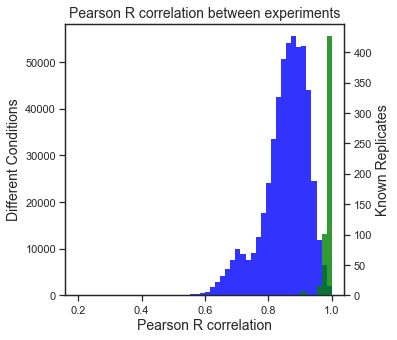

In [34]:
sns.set_style('ticks')

fig,ax = plt.subplots(figsize=(5,5))
ax2 = ax.twinx()
ax2.hist(rep_corrs.values(),bins=50,range=(0.2,1),alpha=0.8,color='green',linewidth=0)
ax.hist(rand_corrs.values(),bins=50,range=(0.2,1),alpha=0.8,color='blue',linewidth=0)
ax.set_title('Pearson R correlation between experiments',fontsize=14)
ax.set_xlabel('Pearson R correlation',fontsize=14)
ax.set_ylabel('Different Conditions',fontsize=14)
ax2.set_ylabel('Known Replicates',fontsize=14)

med_corr = np.median([v for k,v in rep_corrs.items()])
print('Median Pearson R between replicates: {:.2f}'.format(med_corr))

For conditions with >2 replicates, ensure that we only drop replicates that are uncorrelated with everything else

In [35]:
corr_thresh = 0.95
dissimilar = []
for full_cond_name, condition_df in DF_metadata_passed.groupby('full_name'):
    rep_corrs_cond = {cond_tup: corr for cond_tup, corr in rep_corrs.items() if cond_tup[0] in condition_df.index or cond_tup[1] in condition_df.index}
    # if there's nothing, there weren't any replicates, this "passes"
    if condition_df.shape[0] == 1:
        continue
    # or if there's just 2, it's simple
    elif condition_df.shape[0] == 2:
        for (cond1, cond2), corr in rep_corrs_cond.items():
            if corr < corr_thresh:
                dissimilar.extend([cond1, cond2])
    # if there's 3 or more replicates, take the ones with the best correlation greedily
    elif condition_df.shape[0] > 2:
        # only need to worry about dissimilar if there's at least one below threshold
        sorted_rep_corrs = sorted(rep_corrs_cond.items(), key=lambda tup: tup[1], reverse=True)

        (top_cond1, top_cond2), top_corr = sorted_rep_corrs[0]
        to_keep = []
        if top_corr >= corr_thresh:
            to_keep = [top_cond1, top_cond2]
            for (cond1, cond2), corr in sorted_rep_corrs[1:]:
                if cond1 in (top_cond1, top_cond2) or cond2 in (top_cond1, top_cond2):
                    if corr >= corr_thresh:
                        to_keep.extend([cond1, cond2])
        dissimilar.extend(set(condition_df.index).difference(set(to_keep)))
        
dissimilar = set(dissimilar)
DF_metadata_passed['passed_similar_replicates'] = ~DF_metadata_passed.index.isin(dissimilar)

/var/folders/q2/bdjskmzs1n9fbb14bmvhdz500000gn/T/ipykernel_61536/3663500301.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DF_metadata_passed['passed_similar_replicates'] = ~DF_metadata_passed.index.isin(dissimilar)


## Number of Replicates

In [36]:
DF_metadata_passed_input = DF_metadata_passed[DF_metadata_passed['passed_similar_replicates']]

In [37]:
# Drop Samples with no replicates
cond_counts = DF_metadata_passed_input.condition.value_counts()
drop_conds = cond_counts[cond_counts < 2].index
print(len(drop_conds))
drop_conds

55


Index(['sdh_ale2', 'PD-009_del-baeR_Fed-batch_18h', 'bw_delcra_trp',
       'PD-004_del-qseB_Batch_6h', 'bw_delcra_glc', 'wt_trp', 'wt_ade',
       'PD-009_del-tnaA_Fed-batch_6h', 'PD-009_del-tnaA_Batch_6h', 'pgi_ale2',
       'delgadx_ph5', 'nitr_031', 'bw_delmntr', 'rpoBE546V_044',
       'bw_delnac_ade', '42c_ale8', '42c_ale10', 'wt_xyl', 'glc_ale1',
       'glc_ale2', 'glc_ale3', 'glyc_ale1', 'xyl_ale1', 'xyl_ale2', 'xyl_ale3',
       'glc_ac_ac2', 'glc_ac_glc1', 'glc_glyc_glc', 'glc_glyc_glyc',
       'glc_xyl_glc', 'glc_xyl_xyl', 'aldA_f1c2', 'aldA_minE', '42c_ale9',
       '42c_ale6', 'bw_delnac_glc', '42c_ale5', '5drib_ale10', 'wt_031',
       'wt_044', 'rpoBE546V_031', 'rpoBE546V_glc', 'lyx_ale2_f6', 'glu_ale3',
       'glu_ale5', 'glu_ale6', 'glu_ale8', 'glu_ale9', 'glu_ale10', 'wt_42c',
       '42c_ale1', '42c_ale2', '42c_ale3', '42c_ale4', 'glyc_ale2'],
      dtype='object')

In [38]:
DF_metadata_passed['passed_number_replicates'] = ~DF_metadata_passed.condition.isin(drop_conds)

/var/folders/q2/bdjskmzs1n9fbb14bmvhdz500000gn/T/ipykernel_61536/2306465293.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DF_metadata_passed['passed_number_replicates'] = ~DF_metadata_passed.condition.isin(drop_conds)


## Remove Replicate Failures

We will allow samples without replicates as our overall confidence in the experimental method based on other biological replicate correlations is very high.

In [39]:
qc_columns = ['passed_similar_replicates']

In [40]:
DF_metadata_final = DF_metadata_passed[DF_metadata_passed[qc_columns].all(axis=1)]

In [41]:
DF_metadata_final.shape

(1035, 41)

In [42]:
DF_log_tpm_final = DF_log_tpm[DF_metadata_final.index]

# Ensure Project Reference

Make sure the designated project reference conditions were not removed

In [43]:
all_references = []
for reference in DF_metadata_final['project_reference'].str.split(';'):
    all_references.extend(reference)
all_references = set(all_references)

assert (set(all_references) - set(DF_metadata_final.index)) == set()

# Remove Small Genes and Low FPM

Small genes are less than 100 nt; these tend to add noise without improving regulon recovery

In [44]:
gene_info = pd.read_csv('../../data/annotation/gene_info.csv', index_col=0)
short_genes = gene_info[(gene_info.end-gene_info.start+1)<100].index.to_list()

counts = pd.read_csv(os.path.join(org_dir, 'counts.csv'), index_col=0)
fpm = counts.divide(counts.sum(axis=0)) * (10**6)
assert fpm['p1k_00001'].sum() == 1000000
low_fpm_genes = fpm.loc[fpm.max(axis=1) < 10].index.to_list()
drop_genes = list(dict.fromkeys(low_fpm_genes + short_genes)) # dict.fromkeys step removes duplicates

In [45]:
DF_log_tpm_final_no_small = DF_log_tpm_final.drop(index=drop_genes, errors='ignore')
DF_log_tpm_final_no_small.shape

(4257, 1035)

# Save Final QCed Datasets

In [46]:
# Define centering reference condition as "control" project, growth in M9 medium with glucose
reference = ['p1k_00001','p1k_00002']

In [47]:
# Subtract mean expression of reference from entire dataset
DF_log_tpm_norm = DF_log_tpm_final_no_small.sub(DF_log_tpm_final_no_small[reference].mean(axis=1),axis=0)

In [48]:
DF_log_tpm_final.to_csv(os.path.join(org_dir,'log_tpm_qc_w_short_low_fpkm.csv'))
DF_log_tpm_final_no_small.to_csv(os.path.join(org_dir,'log_tpm_qc.csv'))
DF_log_tpm_norm.to_csv(os.path.join(org_dir,'log_tpm_norm_qc.csv'))
DF_metadata_final.to_csv(os.path.join(org_dir,'metadata_qc.csv'))

# Update Gene Info Table

In [49]:
gene_table = pd.read_csv('../../data/annotation/gene_info.csv', index_col=0)

In [50]:
gene_table = gene_table.assign(
    # add indicator if in final PRECISE-1K
    p1k=gene_table.index.isin(DF_log_tpm_norm.index),
    # add reference condition mean expression for ALL genes (incl. small ones not in P1K)
    # also P1K median expression and median absolute deviation
    p1k_ctrl_log_tpm=DF_log_tpm_final[reference].mean(axis=1).loc[gene_table.index],
    p1k_median_log_tpm=DF_log_tpm_final.median(axis=1).loc[gene_table.index],
    p1k_mad_log_tpm=DF_log_tpm_final.apply(stats.median_absolute_deviation, axis=1).loc[gene_table.index]
)

In [51]:
gene_table.to_csv('../../data/annotation/gene_info.csv')